In [24]:
import numpy as np
import torch
import math
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import pytest

In [2]:
U_1 = torch.tensor(np.array(Image.open('cuadro1_005.bmp').convert('L')))
U_1.shape

torch.Size([455, 756])

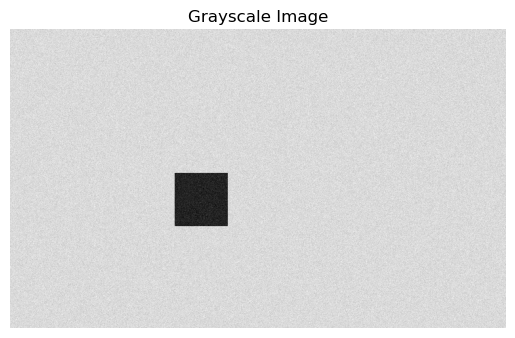

In [3]:
plt.imshow(U_1, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')
plt.show()

In [4]:
U_1_1D = U_1.view(-1)
U_1_1D.shape

torch.Size([343980])

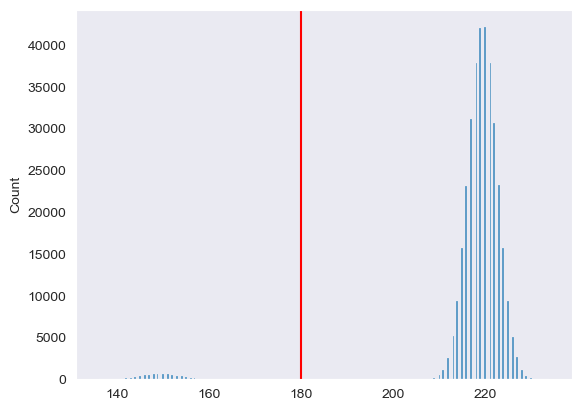

In [5]:
sns.set_style('dark')
sns.histplot(U_1_1D, bins=256)
plt.axvline(x=180, color='r', linestyle='-')
plt.show()

In [6]:
#for i in range(len(U_1_1D)):
#  if U_1_1D[i]>=180:
#    U_1_1D[i]=0
#  else:
#    U_1_1D[i]=255

U_1_restored = U_1_1D.reshape(U_1.shape)

In [7]:
# M= Muestra ya separada por campanas
# L = Longitud de la muestra total, viene de la funcion momentos_estadisticos -->  len(p) --> len(U_1_1D)
def calculate_p_x(M,l):
    P=[]

    z= torch.unique(M)
    
    #Aca se cuenta la cantidad de ocurrencias de i en el tensor M, es decir va sumando cuantas veces existe un valor
    for i in z:
        count= torch.sum(torch.eq(M, i))
        # Se divide la cantidad de veces que aparece i entre la muestra total
        p = count/l
        P.append(p)
#P es un tensor con la funcion de densidad, equivalente a h(z)
    P = torch.tensor(P)

    #El peso es la relacion entre ambas campanas, seria propiamente p1 y p2, la sumatoria de todos los valores de la campana
    peso = torch.sum(P)
    
    #mu es la sumatoria de P aka h (z) * z, por el peso^-1
    mu = torch.sum(P*z)*pow(peso,-1)
    
    sigma = torch.sum(P* torch.pow(z-mu,2))*pow(peso,-1)
    print(f'peso: {peso}')
    print(f'mu: {mu}')
    print(f'sigma: {sigma}')
    return peso, mu, sigma

#Esta funcion divide el dataset en dos grupos a partir del posible tao, es decir para este momento ya se tuvo
#que haber calculado un histograma

def calcular_momentos_estadisticos(T,p):
    bell_1 = []
    bell_2= []
    l=len(p)

    
    for i in p:
        if i<T:
            bell_1.append(i)
            
        else:
            bell_2.append(i)
    bell_1 = torch.tensor(bell_1)

    bell_2 = torch.tensor(bell_2)

    
    w1, mu1, sigma1 = calculate_p_x(bell_1,l)
    w2, mu2, sigma2 = calculate_p_x(bell_2,l)

    return w1, mu1, sigma1, w2, mu2, sigma2

w1, mu1, sigma1, w2, mu2, sigma2 = calcular_momentos_estadisticos(180,U_1_1D)

peso: 0.019073784351348877
mu: 149.45175170898438
sigma: 15.366405487060547
peso: 0.9809261560440063
mu: 219.49269104003906
sigma: 10.054693222045898


A continuación se van a diseñar pruebas para corroborar el funcionamiento de las funciones calculate_p_x y calcular_momentos_estadísticos.

Prueba unitaria 1: Se van a dividir manualmente los datos del ejercicio TP01 para calcular sus parametros mediante la biblioteca de numpy, y corroborar estos con los obtenidos por la funcion calculate_p_x

In [8]:
T= 180
bell_1 = []
bell_2 = []
for i in U_1_1D:
        if i<T:
            bell_1.append(i)
            
        else:
            bell_2.append(i)

In [9]:
print("mean", np.mean(bell_1))
print("stdev" , np.std(bell_1))
print("varianza", np.var(bell_1))

mean 149.4517604023777
stdev 3.920000617582368
varianza 15.366404841846146


In [10]:
print("mean", np.mean(bell_2))
print("stdev" , np.std(bell_2))
print("varianza", np.var(bell_2))

mean 219.4926663880813
stdev 3.1709136587963913
varianza 10.054693431541518


Valores obtenidos con las funciones:  
peso: 0.019073784351348877  
mu: 149.45175170898438  
sigma: 15.366405487060547  
peso: 0.9809261560440063  
mu: 219.49269104003906  
sigma: 10.054693222045898  

Prueba unitaria 2: Verificar que los resultados son numeros reales y no valores Nan a partir de otro set de datos

In [11]:
def test_no_nan_results():
    T = 3.5
    p = torch.tensor([1.2, 2.5, 3.0, 4.5, 5.2, 6.0])  
    
    w1, mu1, sigma1, w2, mu2, sigma2 = calcular_momentos_estadisticos(T, p)
    
    # Comprueba que los resultados no son NaN
    assert not torch.isnan(w1)
    assert not torch.isnan(mu1)
    assert not torch.isnan(sigma1)
    assert not torch.isnan(w2)
    assert not torch.isnan(mu2)
    assert not torch.isnan(sigma2)

test_no_nan_results()

peso: 0.5
mu: 2.2333333492279053
sigma: 0.5755555629730225
peso: 0.5
mu: 5.233333587646484
sigma: 0.3755555748939514


Prueba unitaria 3: Verificar el funcionamiento correcto de la función calcular_momentos_estadisticos a partir de un dataset generado aleatoriamente, con una distribución gaussiana mixta, de la que podemos obtener la esperanza y la varianza por cálculos mediante la libreria numpy, es decir, en la que se saben los resultados de antemano.

In [12]:
# Primero se generan dos distribuciones separadas y se calculan sus parametros
dist1 = np.random.normal(45,6,250)
dist2 = np.random.normal(500,14,10000)

<Axes: ylabel='Count'>

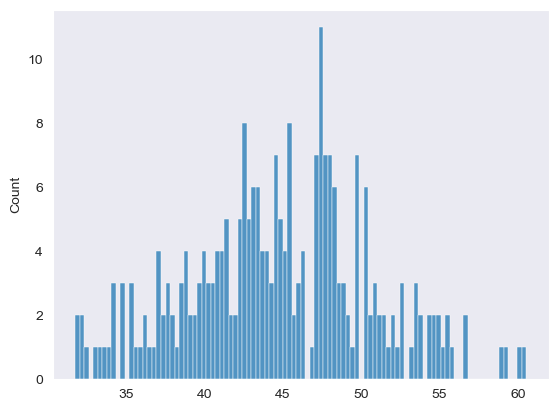

In [13]:
sns.set_style('dark')
sns.histplot(dist1, bins=100)

<Axes: ylabel='Count'>

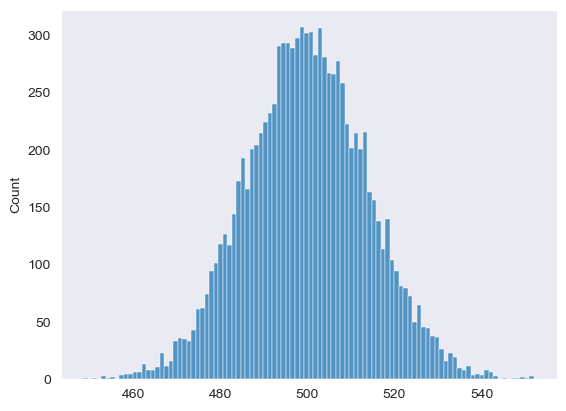

In [14]:
sns.set_style('dark')
sns.histplot(dist2, bins=100)

In [22]:
# A continuación se calculan los valores mediante las funciones de np
mean1 = np.mean(dist1)
var1 = np.var(dist1)
stdev1 = np.std(dist1)
mean2 = np.mean(dist2)
var2 = np.var(dist2)
stdev2 = np.std(dist2)



print("El valor de la media de la primera distribucion es: ", mean1)
print("El valor de stdev de la primera distribucion es: ",stdev1)
print("El valor de la varianza de la primera distribucion es: ",var1)

print("El valor de la media de la segunda distribucion es: ", mean2)
print("El valor de stdev de la segunda distribucion es: ",stdev2)
print("El valor de la varianza de la segunda distribucion es: ",var2)

El valor de la media de la primera distribucion es:  44.7417653311282
El valor de stdev de la primera distribucion es:  5.843585135301214
El valor de la varianza de la primera distribucion es:  34.14748723351331
El valor de la media de la segunda distribucion es:  499.93607125230983
El valor de stdev de la segunda distribucion es:  13.938923577227255
El valor de la varianza de la segunda distribucion es:  194.29359049178188


In [16]:
# Se prueba la funcion calculate_p_x
calculate_p_x(torch.tensor(dist1), len(dist1))
calculate_p_x(torch.tensor(dist2), len(dist2))

peso: 1.0000001192092896
mu: 44.74176212261371
sigma: 34.147484784744336
peso: 0.9999995827674866
mu: 499.9362970109519
sigma: 194.29367828088118


(tensor(1.0000),
 tensor(499.9363, dtype=torch.float64),
 tensor(194.2937, dtype=torch.float64))

Mediante estos calculos se comprueba que los resultados de la funcion calculate_p_x son esperados

In [17]:
# A continuación se van a unir ambas distribuciones, para definir un tao y comparar los resultados
dist3 = np.concatenate([dist1, dist2])

# Verificar la forma y tamaño de dist3
print("Forma de dist3:", dist3.shape)
print("Tamaño de dist3:", len(dist3))

Forma de dist3: (10250,)
Tamaño de dist3: 10250


<Axes: ylabel='Count'>

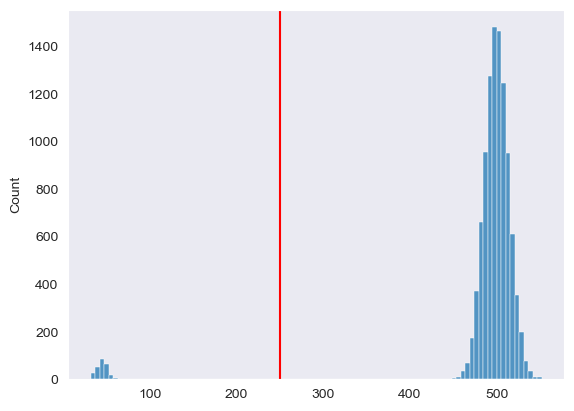

In [18]:
sns.set_style('dark')
plt.axvline(x=250, color='r', linestyle='-')
sns.histplot(dist3, bins=100)

In [19]:
# Se ejecuta la función calcular_momentos_estadisticos con esta nueva distribución
w3, mu3, sigma3, w4, mu4, sigma4 = calcular_momentos_estadisticos(250,torch.tensor(dist3))

peso: 0.024390242993831635
mu: 44.741764038086544
sigma: 34.147486246649066
peso: 0.9756096601486206
mu: 499.9361033188546
sigma: 194.2936029550518


In [25]:
# Se genera la prueba unitaria, utilizando como valores de referencia los parametros calculados mediante numpy
def test_calcular_momentos_estadisticos():
    T = 250
    p = dist3  # Muestra de ejemplo sin valores iguales a T

    w1, mu1, sigma1, w2, mu2, sigma2 = calcular_momentos_estadisticos(T, p)

    # Comprueba los resultados esperados
    #assert w1 == pytest.approx(0.4)
    assert mu1 == pytest.approx(mean1)
    assert sigma1 == pytest.approx(var1)
    #assert w2 == pytest.approx(499.9280)
    assert mu2 == pytest.approx(mean2)
    assert sigma2 == pytest.approx(var2)
    
test_calcular_momentos_estadisticos()

peso: 0.024390242993831635
mu: 44.741764038086544
sigma: 34.147486246649066
peso: 0.9756096601486206
mu: 499.9361033188546
sigma: 194.2936029550518


Si la comparación de los valores de esperanza y varianza no hubieran sido iguales entre la función y los calculados por numpy, el código anterior hubiese fallado, ya que la función assert compara la igualdad entre ambos valores.

In [26]:
print(U_1)

tensor([[219, 218, 219,  ..., 221, 216, 217],
        [220, 221, 220,  ..., 222, 220, 225],
        [216, 214, 220,  ..., 222, 220, 220],
        ...,
        [218, 219, 220,  ..., 221, 221, 217],
        [226, 219, 219,  ..., 219, 224, 221],
        [217, 223, 220,  ..., 221, 225, 224]], dtype=torch.uint8)


Como la distincion entre los pixeles es tan clara se va a hacer una funcion que itere sobre este tensor para modificar los valores a 0 o 255

In [35]:
def convert_tensor_values(tensor):
    # Crea un tensor de salida con las mismas dimensiones y tipo de datos
    output_tensor = torch.zeros_like(tensor)
    
    # Itera sobre los elementos del tensor
    for i in range(tensor.size(0)):
        for j in range(tensor.size(1)):
            # Comprueba el valor de cada elemento y realiza la conversión correspondiente
            if tensor[i, j] > 180:
                output_tensor[i, j] = 255
            else:
                output_tensor[i, j] = 1
    
    return output_tensor

In [36]:
U_2 = convert_tensor_values(U_1)

In [37]:
print(U_2)

tensor([[255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255],
        ...,
        [255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255]], dtype=torch.uint8)


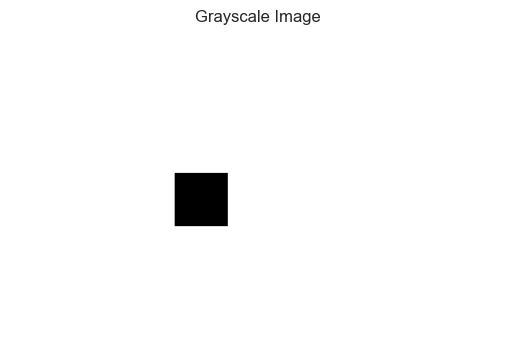

In [38]:
plt.imshow(U_2, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')
plt.show()

Si lo que se ocupa es modificar el valor a 0s y 1s entonces se puede actualizar la funcion que genera el ground truth 

Entonces ya tengo un tensor de referencia que va a ser parte de la entrada para la matriz de confusion :)